# Exploratory Data Analysis of Pollen Dataset: A Scientific Analysis

Nils Fahrni  
Etienne Roulet  
2025-03-28

# Abstract

This report presents a systematic exploratory data analysis of a pollen
dataset consisting of 2D image views generated from STL models. We
detail the methodology used to load the dataset, visualize sample
images, compute key image statistics such as brightness, disparity maps,
sharpness, and entropy, and assess structural similarity between image
pairs. The findings provide insights into the quality and
characteristics of the dataset, laying the groundwork for further
investigation.

# Introduction

Pollen imaging offers valuable insights into the morphology and
structural properties of pollen grains. In this study, we analyze a
dataset composed of paired left and right view images extracted from STL
models. Our objectives include:

-   Visualizing random samples from the dataset.
-   Computing statistical metrics including mean intensity, standard
    deviation, and pixel intensity histograms.
-   Generating a disparity map to approximate depth information.
-   Evaluating image quality via sharpness, structural similarity
    (SSIM), and entropy measures.

These experiments facilitate a deeper understanding of the dataset’s
overall quality and variability, which is critical for downstream
processing and analysis.

# Materials and Methods

The analysis is implemented using several Python libraries: -
**PyTorch** and **Torchvision** for dataset handling and image
transformations. - **Matplotlib** and **Seaborn** for visualization. -
**OpenCV** for computing disparity maps and additional image processing
tasks. - **PIL** for image handling.

The custom `PollenDataset` class (imported from a separate module) is
used to load the paired image views and associated STL metadata.
Environmental variables define the data directories, ensuring a
reproducible workflow.

# Experiment 1: Dataset Loading and Sample Visualization

In this experiment, we load the pollen dataset and visualize a few
random samples. Each sample includes a left view, a right view, and a
combined view.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import cv2  # OpenCV for disparity map

sys.path.append("..")
from data import PollenDataset

data_dir = os.getenv("DATA_DIR_PATH")
data_dir = os.path.join(data_dir, "raw")
processed_data_dir = os.getenv("DATA_DIR_PATH_PROCESSED")
print(f"Dataset directory: {data_dir}")

dataset = PollenDataset(image_transforms=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

(left_img, right_img), (vertices, faces) = dataset[0]
print(f"Total number of samples in dataset: {len(dataset)}")

Dataset directory: C:/Users/super/Documents/GitHub/sequoia/data\raw
Total number of samples in dataset: 207

The following code visualizes three samples by displaying the left view,
right view, and a combined view side by side.

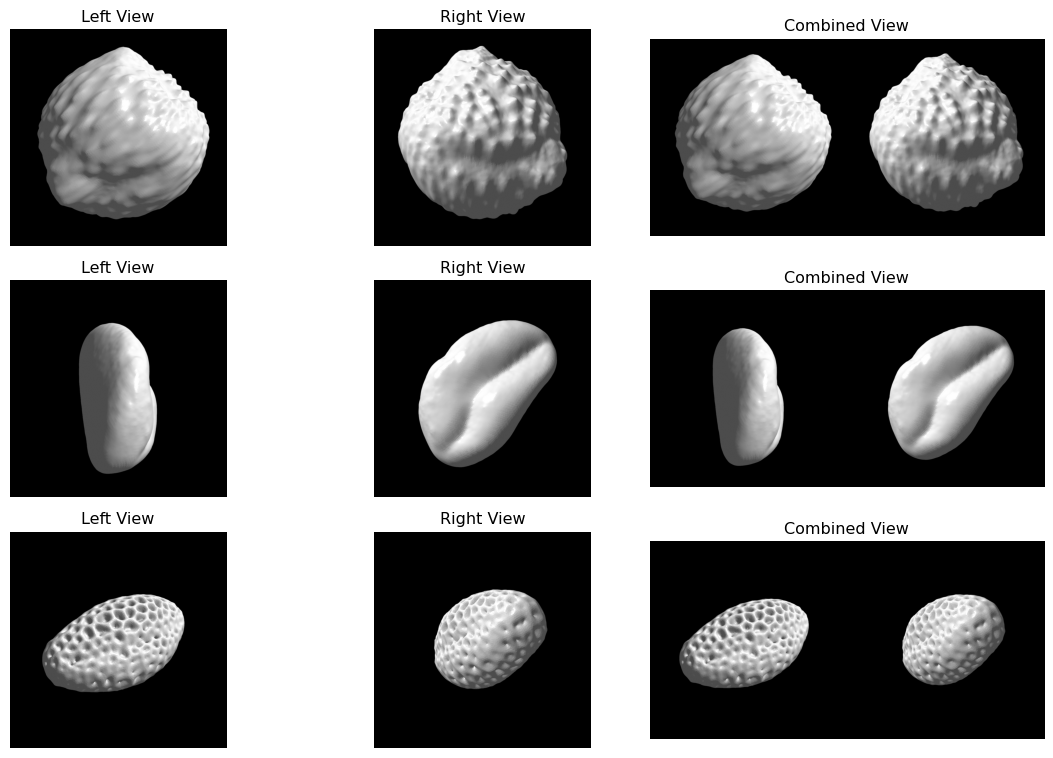

In [2]:
num_samples = 3
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 8))

for i in range(num_samples):
    sample = dataset[i]
    (left_img, right_img), (vertices, faces) = sample
    left_img = left_img.numpy().squeeze()
    right_img = right_img.numpy().squeeze()

    combined = np.hstack([left_img, right_img])

    axes[i, 0].imshow(left_img, cmap='gray')
    axes[i, 0].set_title("Left View")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(right_img, cmap='gray')
    axes[i, 1].set_title("Right View")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(combined, cmap='gray')
    axes[i, 2].set_title("Combined View")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

# Experiment 2: Image Statistics Computation

This experiment computes key metrics for each image to quantify
brightness and contrast characteristics. We calculate the mean
intensity, standard deviation, and pixel intensity histograms.

In [3]:
def compute_image_metrics(image):
    image = image.numpy().squeeze() * 255
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    hist, _ = np.histogram(image, bins=256, range=(0, 256))
    return mean_intensity, std_intensity, hist

mean_intensities = []
std_intensities = []
histograms = []

for sample in dataset:
    (left_img, right_img), (vertices, faces) = sample
    for img in [left_img, right_img]:
        mean_intensity, std_intensity, hist = compute_image_metrics(img)
        mean_intensities.append(mean_intensity)
        std_intensities.append(std_intensity)
        histograms.append(hist)

Visualizations of the computed statistics are generated below.

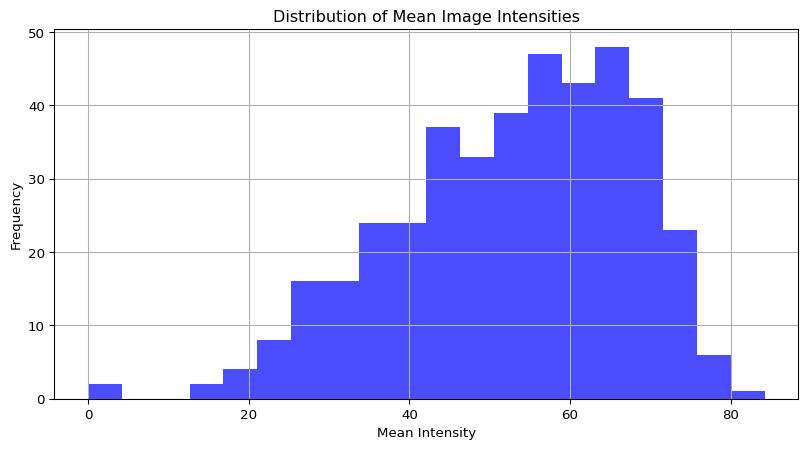

In [4]:
plt.figure(figsize=(10, 5))
plt.hist(mean_intensities, bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Mean Image Intensities")
plt.xlabel("Mean Intensity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

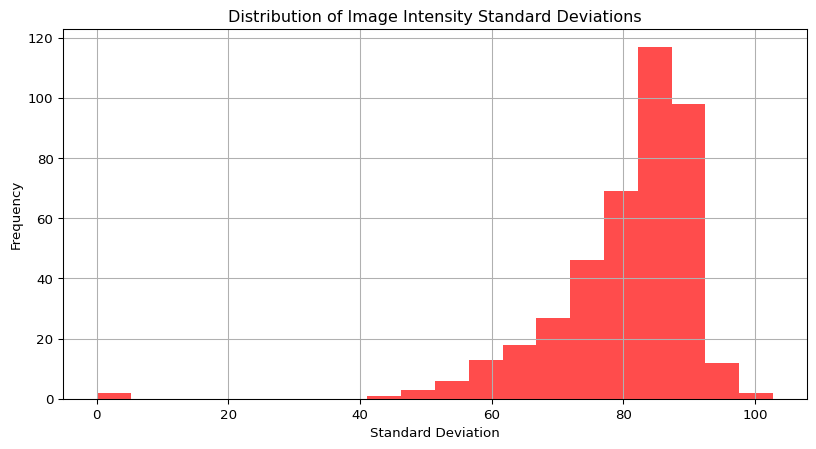

In [5]:
plt.figure(figsize=(10, 5))
plt.hist(std_intensities, bins=20, color='red', alpha=0.7)
plt.title("Distribution of Image Intensity Standard Deviations")
plt.xlabel("Standard Deviation")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The following plot illustrates sample histograms of pixel intensities.

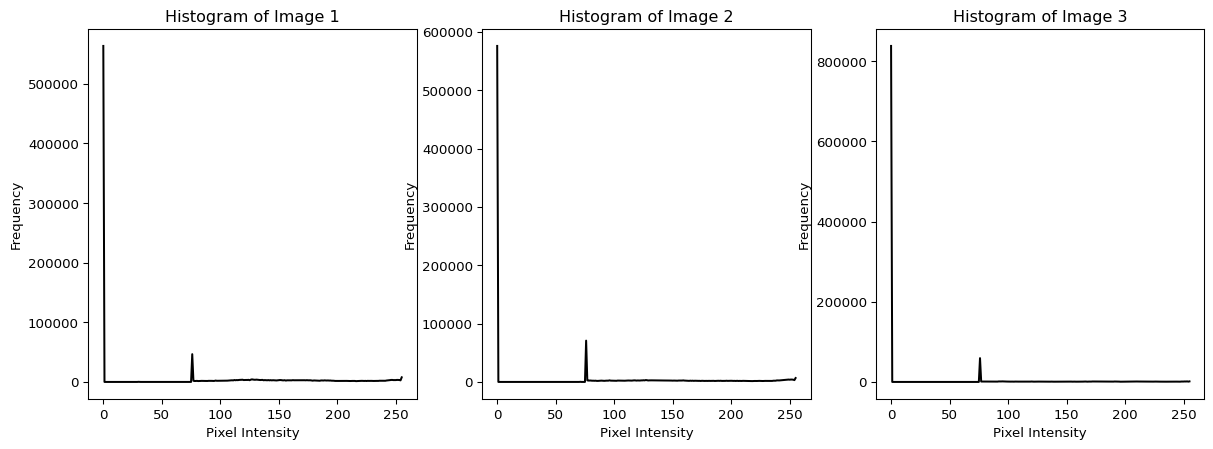

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].plot(histograms[i], color='black')
    axes[i].set_title(f"Histogram of Image {i+1}")
    axes[i].set_xlabel("Pixel Intensity")
    axes[i].set_ylabel("Frequency")
plt.show()

# Experiment 3: Disparity Map and Additional Image Metrics

This experiment explores further image quality metrics by computing a
disparity map, assessing image sharpness, structural similarity (SSIM),
and entropy.

## Disparity Map Computation

A simple stereo block matching algorithm is used to compute a disparity
map from the left and right views.

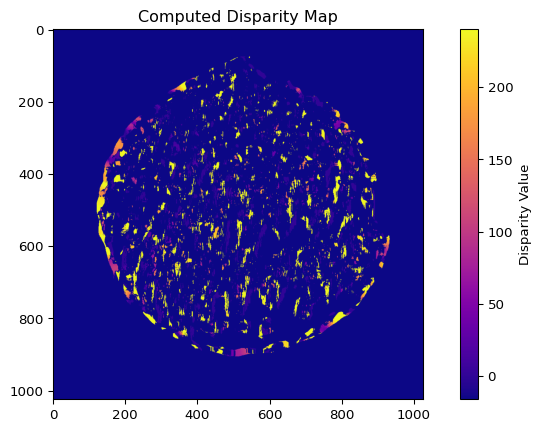

In [7]:
sample = dataset[0]
(left_img, right_img), (vertices, faces) = sample

left_img_np = left_img.numpy().squeeze()
right_img_np = right_img.numpy().squeeze()

left_img_uint8 = (left_img_np * 255).astype(np.uint8)
right_img_uint8 = (right_img_np * 255).astype(np.uint8)

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(left_img_uint8, right_img_uint8)

plt.figure(figsize=(10, 5))
plt.imshow(disparity, cmap='plasma')
plt.colorbar(label="Disparity Value")
plt.title("Computed Disparity Map")
plt.show()

## Image Sharpness Analysis

The sharpness of each image is quantified using the variance of the
Laplacian operator.

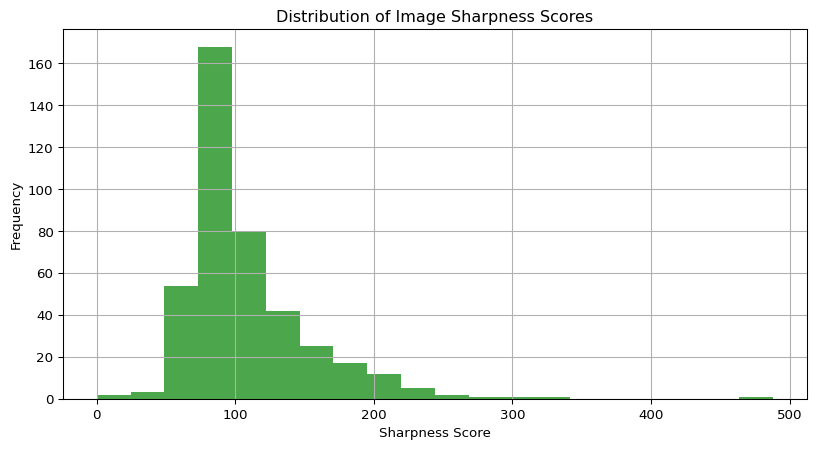

In [8]:
def image_sharpness(image):
    image = (image.numpy().squeeze() * 255).astype(np.uint8)
    return cv2.Laplacian(image, cv2.CV_64F).var()

sharpness_scores = [image_sharpness(img) for sample in dataset for img in sample[0]]

plt.figure(figsize=(10, 5))
plt.hist(sharpness_scores, bins=20, color='green', alpha=0.7)
plt.title("Distribution of Image Sharpness Scores")
plt.xlabel("Sharpness Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Structural Similarity (SSIM) Analysis

SSIM scores are computed to assess the similarity between left and right
views for each sample.

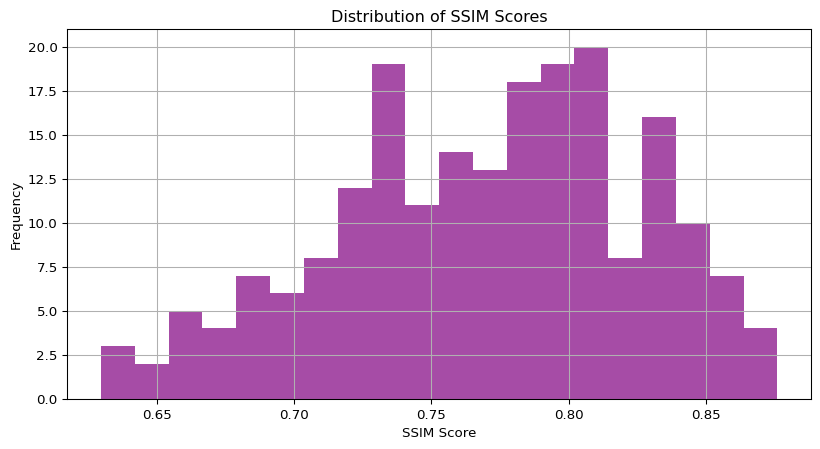

In [9]:
from skimage.metrics import structural_similarity as ssim

ssim_scores = []
for sample in dataset:
    left, right = sample[0]
    left_np = left.numpy().squeeze()
    right_np = right.numpy().squeeze()
    # data_range entspricht der Differenz zwischen maximalem und minimalem Pixelwert
    data_range = left_np.max() - left_np.min()
    score, _ = ssim(left_np, right_np, full=True, data_range=data_range)
    ssim_scores.append(score)

plt.figure(figsize=(10, 5))
plt.hist(ssim_scores, bins=20, color='purple', alpha=0.7)
plt.title("Distribution of SSIM Scores")
plt.xlabel("SSIM Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Entropy Analysis

Image entropy is computed to evaluate the randomness in pixel intensity
distribution.

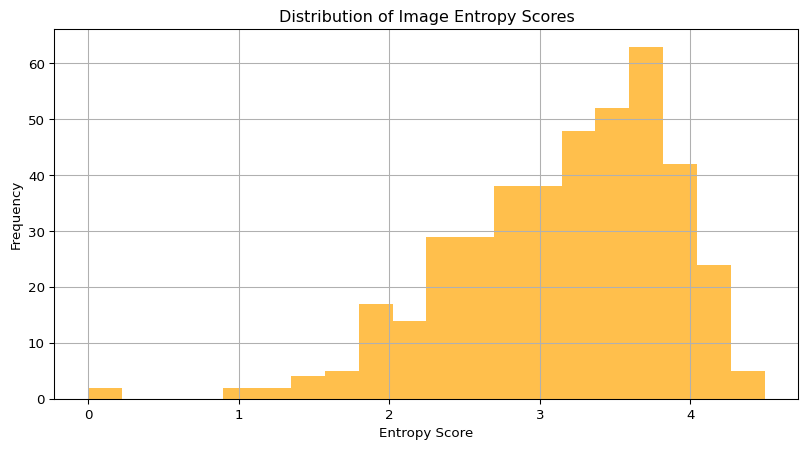

In [10]:
from skimage.measure import shannon_entropy

entropy_scores = [shannon_entropy(img.numpy().squeeze()) for sample in dataset for img in sample[0]]

plt.figure(figsize=(10, 5))
plt.hist(entropy_scores, bins=20, color='orange', alpha=0.7)
plt.title("Distribution of Image Entropy Scores")
plt.xlabel("Entropy Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Brightness Comparison Between Left and Right Views

A scatter plot and histograms compare the mean brightness of left and
right images across the dataset.

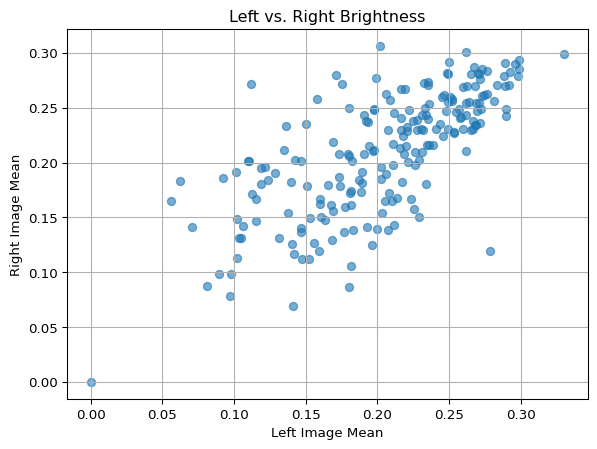

In [11]:
left_means = []
right_means = []
for sample in dataset:
    left, right = sample[0]
    left_means.append(np.mean(left.numpy()))
    right_means.append(np.mean(right.numpy()))

plt.scatter(left_means, right_means, alpha=0.6)
plt.xlabel("Left Image Mean")
plt.ylabel("Right Image Mean")
plt.title("Left vs. Right Brightness")
plt.grid(True)
plt.show()

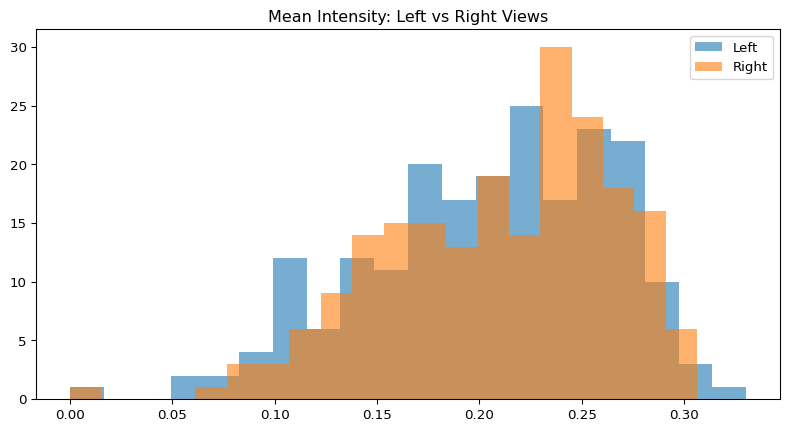

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
left_vals = [np.mean(sample[0][0].numpy()) for sample in dataset]
right_vals = [np.mean(sample[0][1].numpy()) for sample in dataset]
ax.hist(left_vals, bins=20, alpha=0.6, label='Left')
ax.hist(right_vals, bins=20, alpha=0.6, label='Right')
ax.legend()
ax.set_title("Mean Intensity: Left vs Right Views")
plt.show()

# Results and Discussion

The experiments reveal several key insights regarding the pollen
dataset:

-   **Sample Visualization:** The left and right views, as well as their
    combined display, confirm that the dataset consistently represents
    pollen images.
-   **Image Statistics:** Histograms of mean intensities and standard
    deviations indicate a generally uniform brightness distribution,
    with minor variations suggesting potential imaging inconsistencies.
-   **Disparity Map:** The computed disparity map provides a basic
    estimation of depth differences between the views, which may be
    refined with more advanced stereo techniques.
-   **Quality Metrics:** Analyses based on image sharpness, SSIM, and
    entropy offer complementary perspectives on image quality. The
    scatter and histogram plots underscore the consistency between left
    and right views while highlighting subtle variations.

# Findings and further steps of the analysis for the preprocessing pipeline

-   todo

# Conclusion

This exploratory analysis of the pollen dataset has provided a
comprehensive overview of image quality and statistical properties
derived from STL-based 2D views. Through a combination of sample
visualization, computation of brightness and contrast metrics, and
evaluation of depth and quality measures, we have identified key trends
and potential anomalies. Future work may extend this analysis by
employing advanced stereo reconstruction methods and deeper statistical
assessments to further enhance dataset understanding.